In [ ]:
import numpy as np
import k3d
import cv2
import open3d as o3d
import PIL.Image
import IPython.display

In [3]:
def load_lidar_data(bin_path):
    """Load LiDAR point cloud from a .bin file."""
    lidar_data = np.fromfile(bin_path, dtype=np.float32)
    lidar_data = lidar_data.reshape(-1, 4)  # 6 fields per point (x, y, z, intensity, ring, timestamp)
    return lidar_data

def visualize_lidar_k3d(points):
    """Visualize LiDAR point cloud using k3d."""
    plot = k3d.plot()
    
    # Extract x, y, z
    positions = points[:, :3].astype(np.float32)

    # Create k3d point cloud object
    point_cloud = k3d.points(positions, point_size=0.1)

    plot += point_cloud
    plot.display()


In [4]:
lidar_file = "01545.bin"

points = load_lidar_data(lidar_file)
print(f"Loaded {points.shape[0]} points")

# Call visualization
visualize_lidar_k3d(points)

Loaded 182248 points


Output()

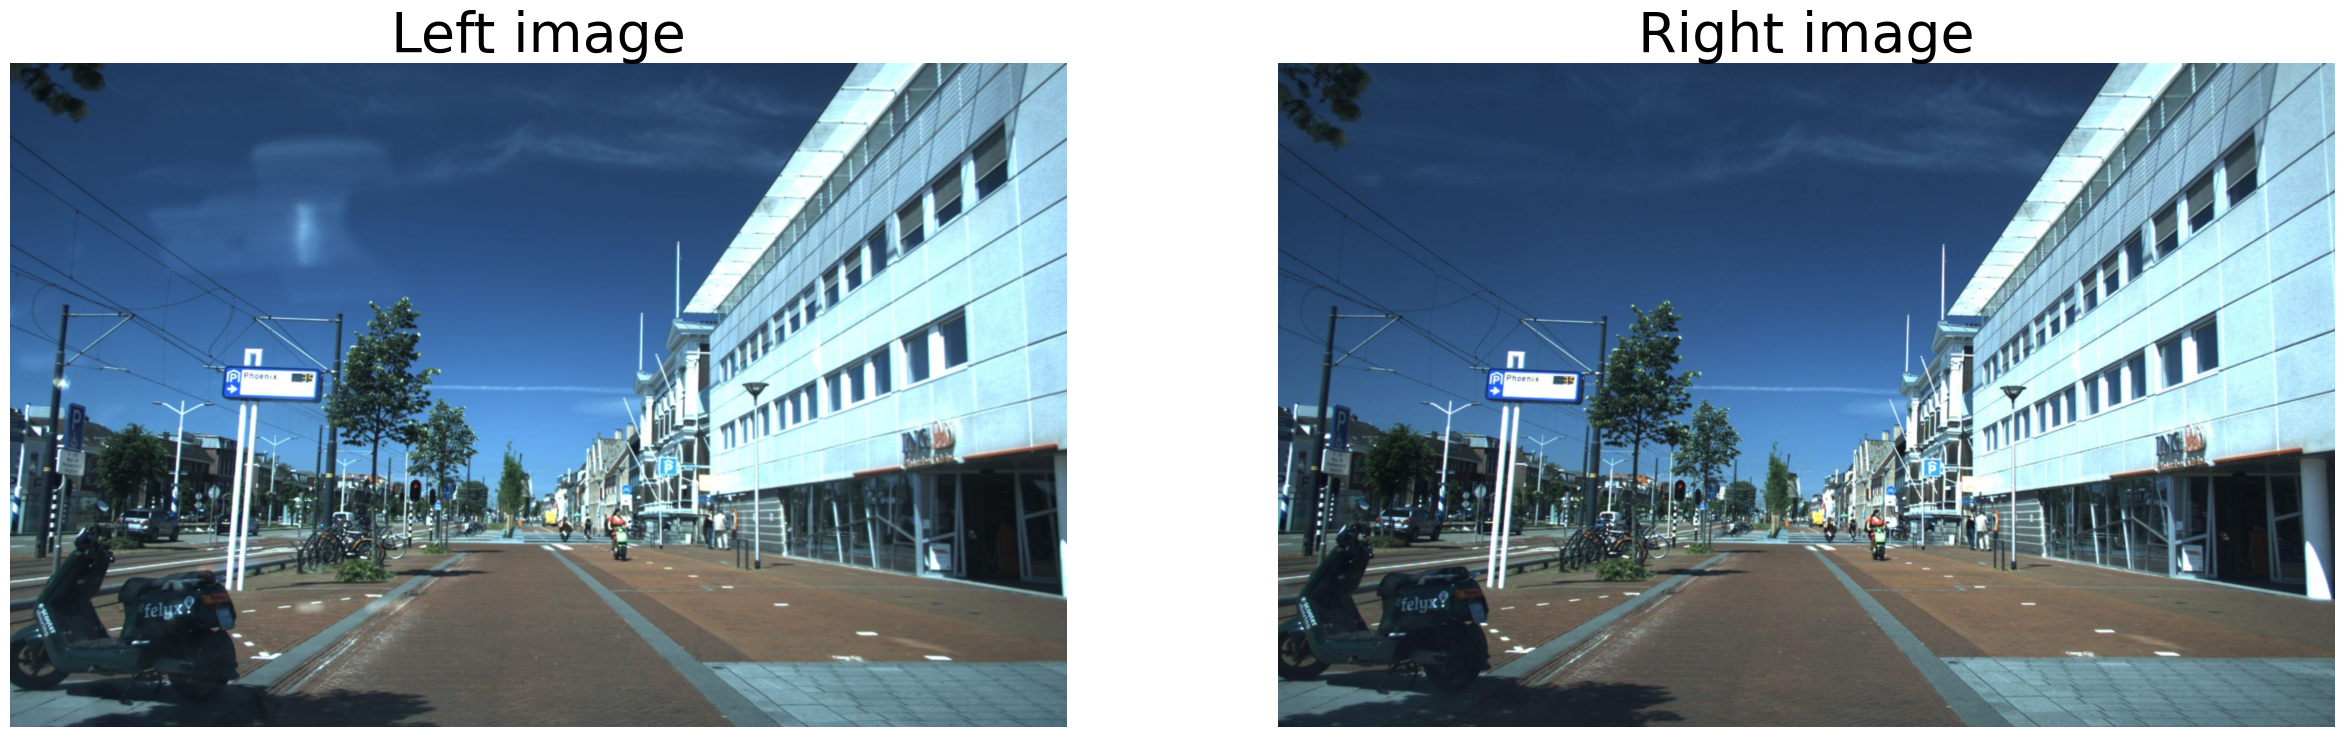

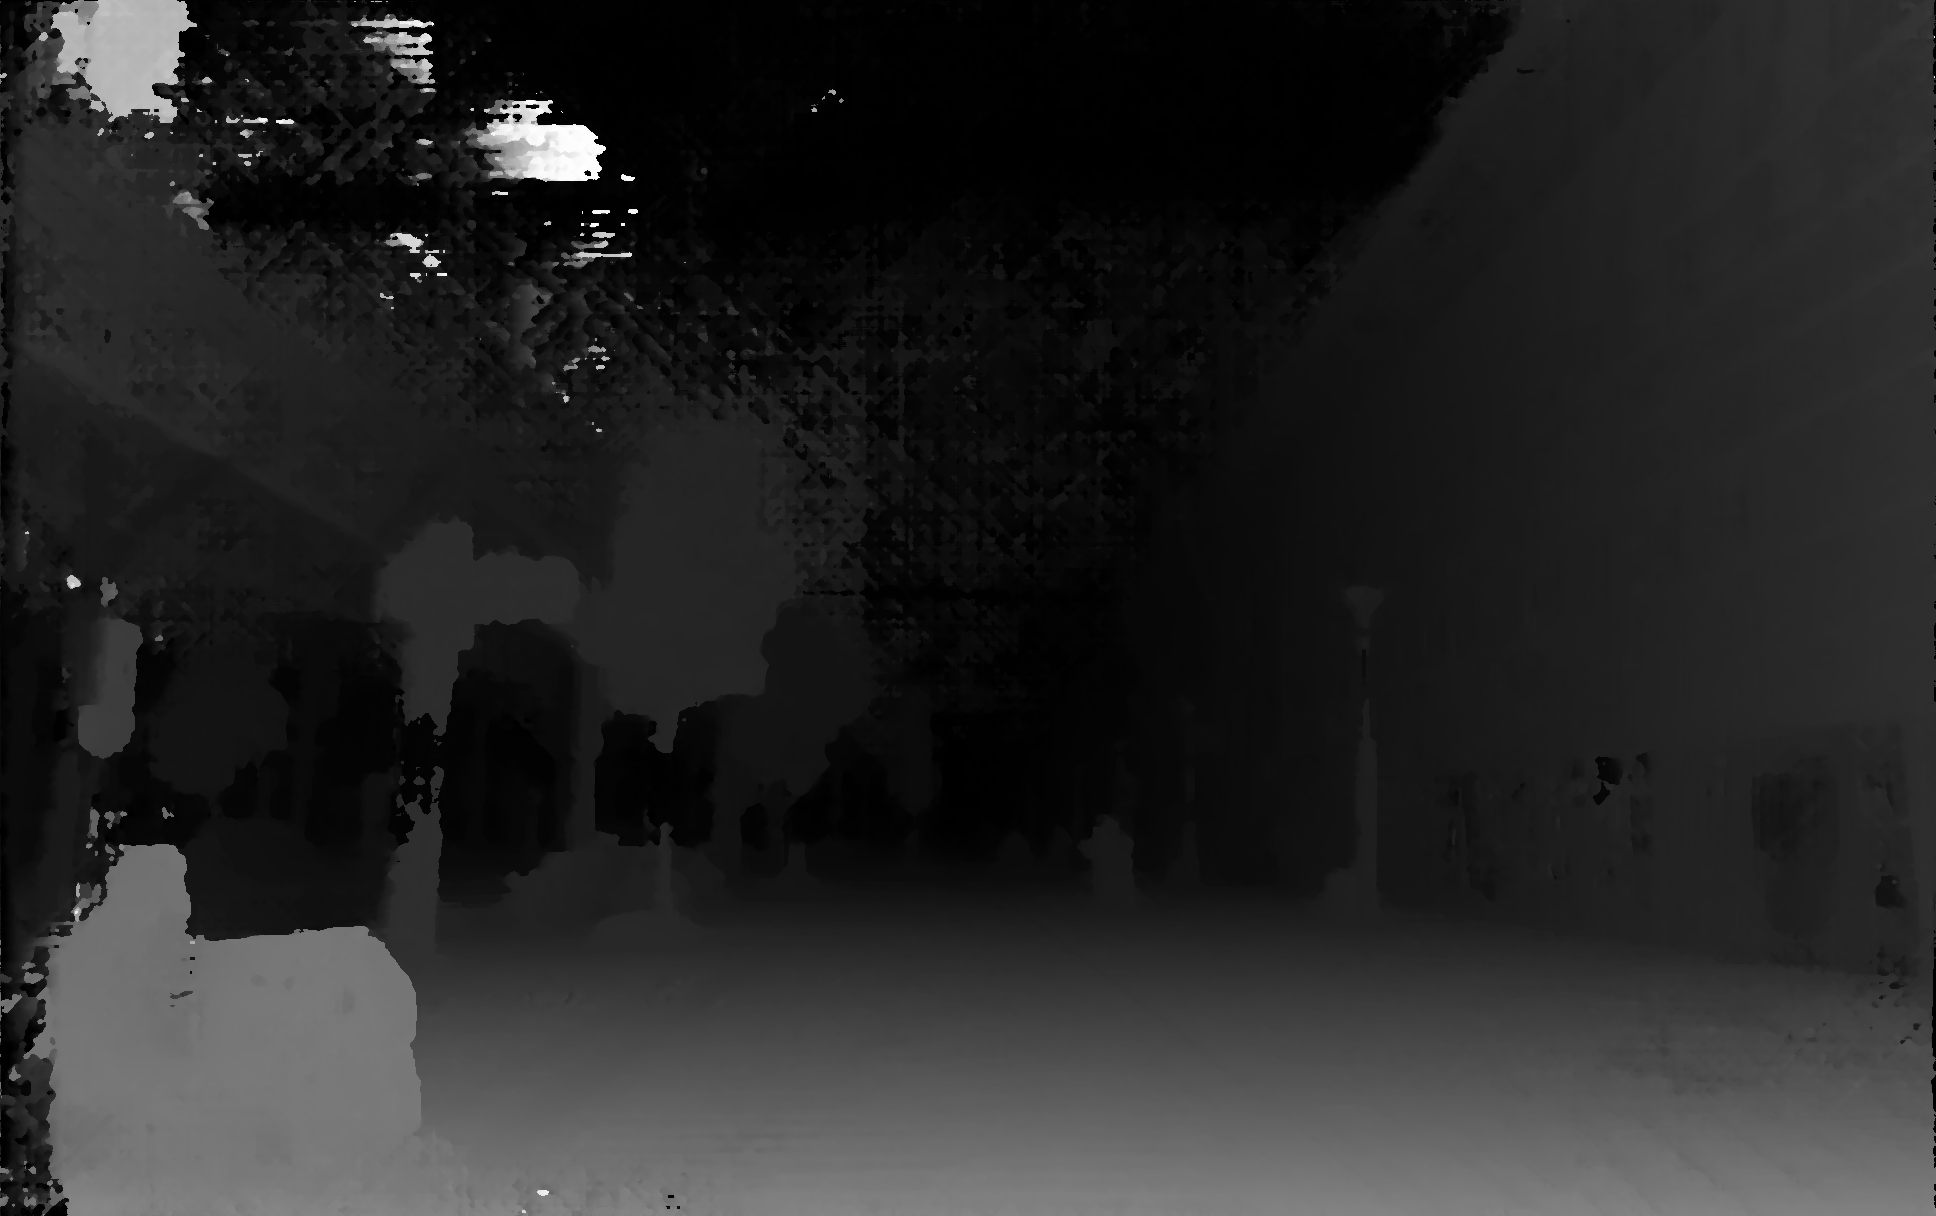

In [5]:
left_img = cv2.imread("01545_left.jpeg", cv2.IMREAD_UNCHANGED)
right_img = cv2.imread("01545_right.jpeg", cv2.IMREAD_UNCHANGED)
disparity_map = cv2.imread("01545.tiff", cv2.IMREAD_UNCHANGED).astype(np.float32)

def showimage(a):
    """Show an image in a Jupyter Notebook cell.
    Expects gray or BGR input (OpenCV default)."""
    # Convert BGR to RGB if needed
    if len(a.shape) > 2 and a.shape[2] == 3:
        a = a[..., ::-1]  # BGR -> RGB
    image = PIL.Image.fromarray(a)
    IPython.display.display(image)  # Display in notebook

# Show left and right image side-by-side.
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(30,30), sharey=True)
axes[0].imshow(left_img[:,:,::-1])
axes[1].imshow(right_img[:,:,::-1])
axes[0].set_title("Left image", fontsize=40)
axes[1].set_title("Right image", fontsize=40)
axes[0].axis('off')
axes[1].axis('off')
plt.show()


# Apply the same normalization as the provided example
normalization_factor = 2
disparity_normalized_uint8 = (disparity_map * normalization_factor).astype(np.uint8)

# Show the disparity image
showimage(disparity_normalized_uint8)


In [ ]:
def extract_projection_matrix(file_path):
    right_projection_matrix = None
    
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("P3:"):  # Look for P3 matrix
                values = list(map(float, line.split()[1:]))  # Extract values after "P3:"
                right_projection_matrix = np.array(values).reshape(3, 4)  # Reshape to 3x4 matrix
                break  # Stop reading once P3 is found

    return right_projection_matrix

# Example usage
# file_path = "View_of_Delft_dataset_PUBLIC/view_of_delft_PUBLIC/lidar/training/calib/01545.txt"
file_path = "01545.txt"  
right_projection_matrix = extract_projection_matrix(file_path)
right_projection_matrix[0,3] = -330.2998   # Public VoD version does not contain T_x so we add it manually.


print(right_projection_matrix)

[[ 1.49546864e+03  0.00000000e+00  9.61272442e+02 -3.30299800e+02]
 [ 0.00000000e+00  1.49546864e+03  6.24895920e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]


In [ ]:



def rgb_to_int(rgb_colors):
    """
    rgb_colors: np.array of size Nx3
    return: np.array of size N
    """
    # Avoid overflow issues with uint8.
    rgb_colors = rgb_colors.astype(np.uint32).T
    int_colors = (rgb_colors[0] << 16) + (rgb_colors[1] << 8) + rgb_colors[2]
    return int_colors

def bgr_to_int(bgr_colors):
    """
    bgr_colors: np.array of size Nx3
    return: np.array of size N
    """
    return rgb_to_int(bgr_colors[:, ::-1])

def compute_3D_from_disparity(right_projection_matrix, disparity_img):
    """
    return: xyz_img (height x width x 3) array that contains the xyz position
        for each pixel in the image or `np.nan`.
    """
    height, width = disparity_img.shape
    xyz_img = np.zeros((height, width, 3))
    
    f = right_projection_matrix[0, 0]
    c_x = right_projection_matrix[0, 2]
    c_y = right_projection_matrix[1, 2]
    T_x = right_projection_matrix[0, 3]
    
    no_occlusions = (disparity_img > 0)
    depth_img = np.full_like(disparity_img, np.nan, dtype=np.float32)
    depth_img[no_occlusions] = (-T_x) / disparity_img[no_occlusions]
    
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    
    # Camera frame
    X_cam = (u - c_x) * depth_img / f
    Y_cam = (v - c_y) * depth_img / f
    Z_cam = depth_img
    
    # Vehicle frame
    X_vehicle = Z_cam
    Y_vehicle = -X_cam
    Z_vehicle = -Y_cam
    
    # xyz_img = np.dstack((X_cam, Y_cam, Z_cam))
    xyz_img = np.dstack((X_vehicle, Y_vehicle, Z_vehicle))
    
    return xyz_img

xyz_img = compute_3D_from_disparity(right_projection_matrix, disparity_map)

In [ ]:
plot = k3d.plot(camera_auto_fit=False, axes_helper=0.0)

left_img_colors = bgr_to_int(left_img[:500, :1000].reshape(-1,3))

plot += k3d.points(positions=xyz_img[:500, :1000].reshape(-1,3).astype(np.float32), point_size=0.025, colors=left_img_colors)
# plot.camera = [0, 0, 0, 0, 0, 15, 0, -1.0, 0]
plot.camera = [0, 0, 0, 15, 0, 0, 0, 0, 1.0]

plot.display()

Output()

In [ ]:
from scipy.spatial import distance

def normalize_point_cloud(pc):
    # Remove mean and scale by standard deviation
    pc -= np.mean(pc, axis=0)
    pc /= np.std(pc, axis=0)
    return pc

# Reshape both point clouds into N x 3 format
points_from_disparity = xyz_img.reshape(-1, 3)
points_from_lidar = points[:, :3]

# # Normalize both point clouds
# points_from_disparity = normalize_point_cloud(points_from_disparity)
# points_from_lidar = normalize_point_cloud(points_from_lidar)

# Remove NaN values from disparity point cloud
mask = ~np.isnan(points_from_disparity).any(axis=1)
points_from_disparity = points_from_disparity[mask]

# Compute Hausdorff distance before ICP alignment
hausdorff_dist = max(
    distance.directed_hausdorff(points_from_disparity, points_from_lidar)[0],
    distance.directed_hausdorff(points_from_lidar, points_from_disparity)[0]
)

print(f"Hausdorff Distance before alignment: {hausdorff_dist}")

# Convert numpy arrays to Open3D pointclouds
pcd_disparity = o3d.geometry.PointCloud()
pcd_disparity.points = o3d.utility.Vector3dVector(points_from_disparity)

pcd_lidar = o3d.geometry.PointCloud()
pcd_lidar.points = o3d.utility.Vector3dVector(points_from_lidar)

# # Remove outliers
# pcd_disparity, _ = pcd_disparity.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
# pcd_lidar, _ = pcd_lidar.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

# Apply ICP alignment
threshold = 0.02
transformation = o3d.pipelines.registration.registration_icp(
    pcd_disparity, pcd_lidar, threshold,
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint()
)

# Apply transformation to disparity pointcloud
pcd_disparity.transform(transformation.transformation)

# Compute Hausdorff distance after ICP alignment
hausdorff_dist = max(
    distance.directed_hausdorff(np.asarray(pcd_disparity.points), np.asarray(pcd_lidar.points))[0],
    distance.directed_hausdorff(np.asarray(pcd_lidar.points), np.asarray(pcd_disparity.points))[0]
)

print(f"Hausdorff Distance after alignment: {hausdorff_dist}")

In [ ]:
# Visualize both point clouds after alignment
o3d.visualization.draw_geometries([pcd_disparity, pcd_lidar])

**Apply PointPillars on combined pointcloud**

In [ ]:
pcd_disparity.tofile("data/kitti/training/velodyne/00001.bin")


In [ ]:
# This executes shell script to run PointPillars inference
!python demo/pcd_demo.py demo/00001.bin \
    configs/pointpillars/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class.py \
    work_dirs/pointpillars/latest.pth

In [ ]:
import pickle

# Load PointPillars results
with open('results.pkl', 'rb') as f:
    pointpillars_bboxes = pickle.load(f)


In [ ]:
plot = k3d.plot()
positions = np.asarray(pcd_disparity.points)
point_cloud = k3d.points(positions, point_size=0.1)
plot += point_cloud

# Draw fused boxes
for bbox in pointpillars_bboxes:
    x, y, z, w, l, h, heading = bbox
    bbox = k3d.bounding_box(bounds=[x-w/2, y-l/2, z-h/2, x+w/2, y+l/2, z+h/2])
    plot += bbox

plot.display()
